In this notebook we are going to try to assess the performances of USAD, but considering exclusively one decoder, instead of two. The performances will be assessed on the SWAT dataset

In [1]:
%cd /nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis

/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis


/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from preprocessing import *
import preprocessing as prp
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data_utils
#from USAD.usad import *
from linear_ae import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from postprocessing import *
import plotly.graph_objects as go
#from USAD.usad_conv import *

import warnings
warnings.filterwarnings('ignore')

# USAD dataset preparation

In [3]:
#Read data
normal = pd.read_csv("data/SWaT_Dataset_Normal_v1.csv")
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)
# Normalization
min_max_scaler = MinMaxScaler()
x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [4]:
#Read data
attack = pd.read_csv("data/SWaT_Dataset_Attack_v0.csv",sep=";")
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)

In [5]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)
# Normalization
x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [6]:
window_size=12 #9 ---> for better reconstruction #12
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]

In [7]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 40
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2] #12*51 = 612
z_size=windows_normal.shape[1]*hidden_size # 12*100 = 1200

#ENCODER:
#612 --> 306
#306 --> 153
#153 --> 1200

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

# Dataset Preparation

In [3]:
dataframe = pd.read_csv(r"/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis/data/train.csv")
dataframe.shape

(1749494, 57)

In [4]:
df=dataframe[['building_id','primary_use', 'timestamp', 'meter_reading', 'sea_level_pressure', 'is_holiday','anomaly']]
df

,building_id,primary_use,timestamp,meter_reading,sea_level_pressure,is_holiday,anomaly
0,1,Education,2016-01-01 00:00:00,NaN,967.2,1,0
1,32,Office,2016-01-01 00:00:00,NaN,967.2,1,0
2,41,Office,2016-01-01 00:00:00,NaN,967.2,1,0
3,55,Office,2016-01-01 00:00:00,NaN,967.2,1,0
4,69,Parking,2016-01-01 00:00:00,NaN,967.2,1,0
...,...,...,...,...,...,...,...
1749489,1316,Entertainment/public assembly,2016-12-31 23:00:00,38.844,967.2,0,0
1749490,1318,Entertainment/public assembly,2016-12-31 23:00:00,202.893,967.2,0,0
1749491,1319,Entertainment/public assembly,2016-12-31 23:00:00,NaN,967.2,0,0
1749492,1323,Office,2016-12-31 23:00:00,172.000,967.2,0,0


In [5]:
imputed_df = impute_nulls(df)
imputed_df

,building_id,primary_use,timestamp,meter_reading,sea_level_pressure,is_holiday,anomaly,is_na
0,1,Education,2016-01-01 00:00:00,31.477940,967.2,1,0,True
200,1,Education,2016-01-01 01:00:00,29.582970,1019.4,1,0,True
398,1,Education,2016-01-01 02:00:00,28.635485,1018.8,1,0,True
597,1,Education,2016-01-01 03:00:00,28.161742,1018.1,1,0,True
796,1,Education,2016-01-01 04:00:00,27.924871,1019.0,1,0,True
...,...,...,...,...,...,...,...,...
1748693,1353,Religious worship,2016-12-31 19:00:00,2.425000,967.2,0,0,False
1748893,1353,Religious worship,2016-12-31 20:00:00,2.450000,967.2,0,0,False
1749093,1353,Religious worship,2016-12-31 21:00:00,2.425000,967.2,0,0,False
1749293,1353,Religious worship,2016-12-31 22:00:00,2.450000,967.2,0,0,False


Now that we have imputed the missing values for the column containing the energy consumption measurements, we can procees by adding a couple of features more and further imputing the missing dates for each timeseries in the dataset.

In [6]:
df = add_trigonometric_features(imputed_df)
df

,building_id,primary_use,timestamp,meter_reading,sea_level_pressure,is_holiday,anomaly,is_na,weekday,weekday_y,weekday_x
0,1,Education,2016-01-01 00:00:00,31.477940,967.2,1,0,True,4,-0.433884,-0.900969
200,1,Education,2016-01-01 01:00:00,29.582970,1019.4,1,0,True,4,-0.433884,-0.900969
398,1,Education,2016-01-01 02:00:00,28.635485,1018.8,1,0,True,4,-0.433884,-0.900969
597,1,Education,2016-01-01 03:00:00,28.161742,1018.1,1,0,True,4,-0.433884,-0.900969
796,1,Education,2016-01-01 04:00:00,27.924871,1019.0,1,0,True,4,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...
1748693,1353,Religious worship,2016-12-31 19:00:00,2.425000,967.2,0,0,False,5,-0.974928,-0.222521
1748893,1353,Religious worship,2016-12-31 20:00:00,2.450000,967.2,0,0,False,5,-0.974928,-0.222521
1749093,1353,Religious worship,2016-12-31 21:00:00,2.425000,967.2,0,0,False,5,-0.974928,-0.222521
1749293,1353,Religious worship,2016-12-31 22:00:00,2.450000,967.2,0,0,False,5,-0.974928,-0.222521


In [7]:
dfs_dict = impute_missing_dates(df)

In [8]:
df1 = pd.concat(dfs_dict.values())
df1

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,is_na,weekday,weekday_y,weekday_x
2016-01-01 00:00:00,1,Education,31.477940,967.2,1,0,True,4,-0.433884,-0.900969
2016-01-01 01:00:00,1,Education,29.582970,1019.4,1,0,True,4,-0.433884,-0.900969
2016-01-01 02:00:00,1,Education,28.635485,1018.8,1,0,True,4,-0.433884,-0.900969
2016-01-01 03:00:00,1,Education,28.161742,1018.1,1,0,True,4,-0.433884,-0.900969
2016-01-01 04:00:00,1,Education,27.924871,1019.0,1,0,True,4,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1353,Religious worship,2.425000,967.2,0,0,False,5,-0.974928,-0.222521
2016-12-31 20:00:00,1353,Religious worship,2.450000,967.2,0,0,False,5,-0.974928,-0.222521
2016-12-31 21:00:00,1353,Religious worship,2.425000,967.2,0,0,False,5,-0.974928,-0.222521
2016-12-31 22:00:00,1353,Religious worship,2.450000,967.2,0,0,False,5,-0.974928,-0.222521


Let's now obtain the train and validation set. We are going to split the dataset into 2 sets, according to the building id.

In [9]:
dfs_train, dfs_val, dfs_test = train_val_test_split(df1)
train = pd.concat(dfs_train.values())

In [10]:
val = pd.concat(dfs_val.values())

In [11]:
test = pd.concat(dfs_test.values())

# Training

In [12]:
train_window = 72

In [13]:
X_train, y_train = create_train_eval_sequences(train, train_window)

In [14]:
X_train.shape, y_train.shape

((1123848, 72, 1), (1123848, 72))

In [15]:
BATCH_SIZE =  128
N_EPOCHS = 40
hidden_size = 1/8

In [16]:
w_size = X_train.shape[1] * X_train.shape[2]
z_size = int(w_size * hidden_size) #X_train.shape[1] * hidden_size 
w_size, z_size

(72, 9)

In [17]:
import torch.utils.data as data_utils

In [18]:
train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(torch.from_numpy(X_train).float().view(([X_train.shape[0], w_size]))), batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)

In [19]:
X_val, y_val = create_train_eval_sequences(val, train_window)

In [20]:
X_val.shape, y_val.shape

((287496, 72, 1), (287496, 72))

In [21]:
val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(torch.from_numpy(X_val).float().view(([X_val.shape[0],w_size]))) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [22]:
device = get_default_device()
device

device(type='cpu')

In [23]:
model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [26]:
N_EPOCHS = 40

In [27]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0051
Epoch [1], val_loss1: 0.0049
Epoch [2], val_loss1: 0.0049
Epoch [3], val_loss1: 0.0048
Epoch [4], val_loss1: 0.0044
Epoch [5], val_loss1: 0.0043
Epoch [6], val_loss1: 0.0042
Epoch [7], val_loss1: 0.0041
Epoch [8], val_loss1: 0.0041
Epoch [9], val_loss1: 0.0038
Epoch [10], val_loss1: 0.0038
Epoch [11], val_loss1: 0.0034
Epoch [12], val_loss1: 0.0033
Epoch [13], val_loss1: 0.0033
Epoch [14], val_loss1: 0.0032
Epoch [15], val_loss1: 0.0033
Epoch [16], val_loss1: 0.0032
Epoch [17], val_loss1: 0.0032
Epoch [18], val_loss1: 0.0032
Epoch [19], val_loss1: 0.0032
Epoch [20], val_loss1: 0.0032
Epoch [21], val_loss1: 0.0032
Epoch [22], val_loss1: 0.0032
Epoch [23], val_loss1: 0.0032
Epoch [24], val_loss1: 0.0032
Epoch [25], val_loss1: 0.0032
Epoch [26], val_loss1: 0.0032
Epoch [27], val_loss1: 0.0032
Epoch [28], val_loss1: 0.0032
Epoch [29], val_loss1: 0.0032
Epoch [30], val_loss1: 0.0032
Epoch [31], val_loss1: 0.0032
Epoch [32], val_loss1: 0.0032
Epoch [33], val_loss

In [ ]:
#history = training(N_EPOCHS,model,train_loader,val_loader) #2.15 min a epoch ---> 7/11% gpu (uni/multi) #Conv_autoencoder: 2.45 min --> 22% gpu

In [11]:
history = np.load("/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis/checkpoints/history_usad_odin.npy", allow_pickle=True) #cambia nome della cartella

In [28]:
history

[0.0050780074670910835,
 0.004906841088086367,
 0.0048859743401408195,
 0.004832207225263119,
 0.004389583133161068,
 0.004298508632928133,
 0.004195685498416424,
 0.0041319881565868855,
 0.0040947492234408855,
 0.0038389626424759626,
 0.003769473871216178,
 0.0034196602646261454,
 0.0033106564078480005,
 0.0032897614873945713,
 0.003242703154683113,
 0.003256776835769415,
 0.003248908556997776,
 0.0032435159664601088,
 0.0032347498927265406,
 0.0032232969533652067,
 0.003201696090400219,
 0.0031889567617326975,
 0.003180338302627206,
 0.0031782600563019514,
 0.003179682418704033,
 0.003168516792356968,
 0.0031781126745045185,
 0.003190371673554182,
 0.0032090407330542803,
 0.003217381192371249,
 0.0032071236055344343,
 0.0032132365740835667,
 0.003219329984858632,
 0.003203244647011161,
 0.003187933936715126,
 0.0031890245154500008,
 0.0031889346428215504,
 0.0031921477057039738,
 0.003197032492607832,
 0.003190729534253478]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


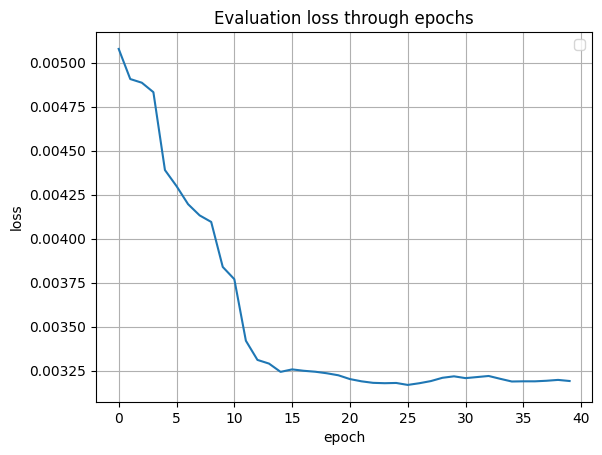

In [29]:
plot_history(history)

In [30]:
print(model)

UsadModel(
  (encoder): Encoder(
    (linear1): Linear(in_features=72, out_features=36, bias=True)
    (linear2): Linear(in_features=36, out_features=18, bias=True)
    (linear3): Linear(in_features=18, out_features=9, bias=True)
    (relu): ReLU(inplace=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=9, out_features=18, bias=True)
    (linear2): Linear(in_features=18, out_features=36, bias=True)
    (linear3): Linear(in_features=36, out_features=72, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  )
)


In [32]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder': model.decoder.state_dict()
            }, "checkpoints/linear_ae_lead_40.pth")

# Testing the model

In [33]:
checkpoint = torch.load("checkpoints/linear_ae_lead_40.pth")#, map_location = torch.device('cpu')) 

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder.load_state_dict(checkpoint['decoder'])
#model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [76]:
X_test, y_test = create_train_eval_sequences(test, train_window)

In [77]:
X_test.shape, y_test.shape

((331056, 72, 1), (331056, 72))

## Testing with non-overlapping windows

In [34]:
X_test, y_test = create_test_sequences(test, train_window) #creo sequenze non overlappate

In [35]:
X_test.shape, y_test.shape #non-overlapping

((4636, 72, 1), (4636, 72))

In [36]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(X_test).float().view(([X_test.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
def reconstruction(model, test_loader):
  # QUI: il test loader che viene passato è ottenuto con non-overlapping sliding window
  tensors_w1 = []
  tensors_w2 = []
  with torch.no_grad():
      for [batch] in test_loader: #N.B.: batch, w1, w2 sono tensori torch.tensor
          batch=to_device(batch,device)
          w1=model.decoder1(model.encoder(batch))
          w2=model.decoder2(model.encoder(w1))
          tensors_w1.append(w1)
          tensors_w2.append(w2)
  # Restituisci solo le ricostruzioni da parte dei due autoencoder
  # Per determinare le anomalie: come facevamo con le baseline, da capire solo come mettere insieme i risultati del primo e del secondo decoder
  # Forse anche qui possiamo calcolare le loss, e almeno per il momento farne una media pesata... no?
  return tensors_w1, tensors_w2

In [ ]:
w1_non_overl, w2_non_overl = reconstruction(model, test_loader)

In [37]:
#w1_non_overl, w2_non_overl = reconstruction(model, test_loader)
results, w = testing_prova(model, test_loader)

In [39]:
w

[tensor([[0.2221, 0.2125, 0.2027,  ..., 0.1623, 0.1720, 0.1809],
         [0.1548, 0.1482, 0.1451,  ..., 0.1496, 0.1509, 0.1525],
         [0.1548, 0.1482, 0.1451,  ..., 0.1496, 0.1509, 0.1525],
         ...,
         [0.4582, 0.4571, 0.4581,  ..., 0.4657, 0.4638, 0.4637],
         [0.4582, 0.4571, 0.4581,  ..., 0.4657, 0.4638, 0.4637],
         [0.4582, 0.4571, 0.4581,  ..., 0.4657, 0.4638, 0.4637]]),
 tensor([[0.4582, 0.4571, 0.4581,  ..., 0.4657, 0.4638, 0.4637],
         [0.4582, 0.4571, 0.4581,  ..., 0.4657, 0.4638, 0.4637],
         [0.4582, 0.4571, 0.4581,  ..., 0.4657, 0.4638, 0.4637],
         ...,
         [0.5080, 0.5068, 0.5125,  ..., 0.5147, 0.4967, 0.4850],
         [0.5161, 0.5167, 0.5189,  ..., 0.5684, 0.5402, 0.5226],
         [0.5411, 0.5370, 0.5348,  ..., 0.5367, 0.5169, 0.5067]]),
 tensor([[0.5322, 0.5252, 0.5162,  ..., 0.5738, 0.5729, 0.5721],
         [0.5322, 0.5274, 0.5261,  ..., 0.5536, 0.5332, 0.5190],
         [0.5022, 0.5013, 0.5042,  ..., 0.4982, 0.4869, 0.

In [41]:
len(w), w[0].size()

(37, torch.Size([128, 72]))

In [ ]:
# CELLA DA FAR GIRARE SE SI STA USANDO usad_conv
w1_new = [torch.reshape(w1_el, (w1_el.size()[0], w1_el.size()[1])) for w1_el in w1_non_overl]
w2_new = [torch.reshape(w2_el, (w2_el.size()[0], w2_el.size()[1])) for w2_el in w2_non_overl]

In [ ]:
len(w1_non_overl), w1_non_overl[0].size(), w1_non_overl[-1].size()

In [ ]:
36*128 + 28

Now that we have our results, given that the input consisted in non overlapping windows, we can just concatenate the values, into creating a single list of reconstructed values, and then perform anomaly detection as usual, by considering the difference with respect to the ground truth.

In [ ]:
# Operations to do for w1 (output of the first autoencoder)
reshaped_w1 = [torch.flatten(w1_el) for w1_el in w1_non_overl]

In [ ]:
len(reshaped_w1), reshaped_w1[0].size(), reshaped_w1[-1].size()

In [ ]:
# Per i primi 36 tensori, che hanno stessa size, possiamo usare stack per ottenere un unico tensore di 36 * 9216 = 331776 elementi
stacked = torch.stack(reshaped_w1[:-1]).flatten()
stacked.shape

In [ ]:
stacked_array = stacked.cpu().numpy()
stacked_array

In [ ]:
last_array = reshaped_w1[-1].cpu().numpy()
last_array

In [ ]:
total = np.concatenate([stacked_array, last_array])

In [ ]:
len(total)

In [ ]:
# SAME for w2
reshaped_w2 = [torch.flatten(w2_el) for w2_el in w2_non_overl]
stacked2 = torch.stack(reshaped_w2[:-1]).flatten()
stacked_array2 = stacked2.cpu().numpy()
last_array2 = reshaped_w2[-1].cpu().numpy()
total2 = np.concatenate([stacked_array2, last_array2])
len(total2)

In [ ]:
total2

Now we need to create the dataset to perform anomaly detection

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
dfs_dict_1 = {}
for building_id, gdf in test.groupby("building_id"):
  gdf[['meter_reading']]=scaler.fit_transform(gdf[['meter_reading']])
  dfs_dict_1[building_id] = gdf
predicted_df_test = pd.concat(dfs_dict_1.values())

In [ ]:
predicted_df_test['reconstruction1'] = total

In [ ]:
predicted_df_test['reconstruction2'] = total2

In [ ]:
predicted_df_test

In [ ]:
predicted_df_test.reconstruction2.min(), predicted_df_test.reconstruction2.max()

In [ ]:
predicted_df_test.reconstruction1.min(), predicted_df_test.reconstruction1.max()

In [ ]:
predicted_df_test['relative_loss'] = np.abs((predicted_df_test['reconstruction1']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction1'])

In [ ]:
predicted_df_test['relative_loss2'] = np.abs((predicted_df_test['reconstruction2']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction2'])

In [ ]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold'].values)
print(thresholds.shape)
predicted_df_test['threshold']= thresholds

In [ ]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss2'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold2']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold2'].values)
print(thresholds.shape)
predicted_df_test['threshold2']= thresholds

In [ ]:
predicted_df_test['predicted_anomaly'] = predicted_df_test['relative_loss'] > predicted_df_test['threshold']
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(False,0)
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(True,1)

In [ ]:
predicted_df_test['predicted_anomaly2'] = predicted_df_test['relative_loss2'] > predicted_df_test['threshold2']
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(False,0)
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(True,1)

In [ ]:
predicted_df_test.index.names=['timestamp']
predicted_df_test= predicted_df_test.reset_index()

In [ ]:
predicted_df_test.predicted_anomaly.unique()

In [ ]:
predicted_df_test.predicted_anomaly2.unique()

In [ ]:
predicted_anomalies = predicted_df_test.loc[predicted_df_test['predicted_anomaly'] == 1]
predicted_anomalies2 = predicted_df_test.loc[predicted_df_test['predicted_anomaly2'] == 1]
true_anomalies = predicted_df_test.loc[predicted_df_test['anomaly'] == 1]

In [ ]:
predicted_df_test = pd.merge(predicted_df_test, df[['timestamp','building_id']], on=['timestamp','building_id'])

In [ ]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly']))

In [ ]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2']))

In [ ]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly'])

In [ ]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2'])

In [ ]:
len(true_anomalies), len(predicted_anomalies), len(predicted_anomalies2)

In [ ]:
len(predicted_anomalies) / len(predicted_df_test), len(predicted_anomalies2) / len(predicted_df_test)

In [ ]:
predicted_df_test.building_id.unique()

In [ ]:
visualizations = predicted_df_test[predicted_df_test.building_id == 1264]
visualizations

In [ ]:
plt.plot(visualizations.meter_reading, label = "meter reading") 
plt.plot(visualizations.reconstruction, label = "w1_reconstruction")
plt.plot(visualizations.reconstruction2, label = "w2_reconstruction")
plt.legend()
plt.show()

In [ ]:
predicted_anomalies = visualizations.loc[visualizations['predicted_anomaly'] == 1]
predicted_anomalies2 = visualizations.loc[visualizations['predicted_anomaly2'] == 1]
true_anomalies = visualizations.loc[visualizations['anomaly'] == 1]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['meter_reading'], name='meter readings'))
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['reconstruction'], name='w1 reconstructed'))
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['reconstruction2'], name='w2 reconstructed'))

fig.add_trace(go.Scatter(x=true_anomalies.index, y=true_anomalies['meter_reading'], mode='markers', marker=dict(color='forestgreen'), name='True_Anomaly'))
fig.add_trace(go.Scatter(x=predicted_anomalies.index, y=predicted_anomalies['meter_reading'], mode='markers', marker=dict(color='yellow'), name='W1_Anomaly'))
fig.add_trace(go.Scatter(x=predicted_anomalies2.index, y=predicted_anomalies2['meter_reading'], mode='markers', marker=dict(color='orange'), name='W2_Anomaly'))
fig.update_layout(showlegend=True, title='meter readings predicted and anomalies - val')
fig.show()

# Testing the model (overlapping windows; anomaly score-based)

In [80]:
X_test, y_test = create_train_eval_sequences(test, 12)

In [81]:
X_test.shape, y_test.shape

((333336, 12, 1), (333336, 12))

In [83]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(X_test).float().view(([X_test.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

RuntimeError: shape '[333336, 612]' is invalid for input of size 4000032

In [34]:
results=testing(model,test_loader) #Prova con il test set #in cpu ci mette 4 secondi (modello con 40 epoch)

In [35]:
results

[tensor([0.0458, 0.0463, 0.0467, 0.0469, 0.0470, 0.0471, 0.0471, 0.0471, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0

Let's create the dataset to perform predictions.

In [36]:
scaler = MinMaxScaler(feature_range=(0,1))

In [37]:
dfs_dict_1 = {}
for building_id, gdf in test.groupby("building_id"):
  gdf[['meter_reading', 'sea_level_pressure']]=scaler.fit_transform(gdf[['meter_reading', 'sea_level_pressure']])
  dfs_dict_1[building_id] = gdf[train_window:]
predicted_df = pd.concat(dfs_dict_1.values())

In [ ]:
lista = []
for el in results:
  for el2 in el:
    lista.append(el2.cpu().item())
lista

In [38]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(), results[-1].flatten().detach().cpu().numpy()])

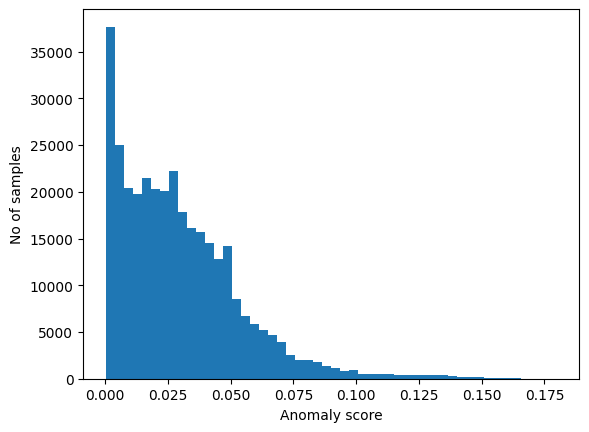

In [40]:
plt.hist(y_pred, bins=50)
plt.xlabel("Anomaly score")
plt.ylabel("No of samples")
plt.show()

In [41]:
predicted_df['anomaly_score'] = y_pred

In [42]:
predicted_df

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,weekday,weekday_y,weekday_x,anomaly_score
2016-01-04 00:00:00,69,Parking,0.139088,0.757143,0,0,0,0.000000,1.000000,0.045797
2016-01-04 01:00:00,69,Parking,0.139088,0.760317,0,0,0,0.000000,1.000000,0.046290
2016-01-04 02:00:00,69,Parking,0.139088,0.746032,0,0,0,0.000000,1.000000,0.046679
2016-01-04 03:00:00,69,Parking,0.139088,0.742857,0,0,0,0.000000,1.000000,0.046907
2016-01-04 04:00:00,69,Parking,0.139088,0.738095,0,0,0,0.000000,1.000000,0.047030
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1319,Entertainment/public assembly,0.336511,0.000000,0,0,5,-0.974928,-0.222521,0.007354
2016-12-31 20:00:00,1319,Entertainment/public assembly,0.336511,0.000000,0,0,5,-0.974928,-0.222521,0.007304
2016-12-31 21:00:00,1319,Entertainment/public assembly,0.336511,0.000000,0,0,5,-0.974928,-0.222521,0.007249
2016-12-31 22:00:00,1319,Entertainment/public assembly,0.336511,0.000000,0,0,5,-0.974928,-0.222521,0.007187


In [43]:
predicted_df.anomaly_score.min(), predicted_df.anomaly_score.max() 

(0.00021257115, 0.17982489)

In [44]:
perc = 90
threshold = (np.percentile(predicted_df.anomaly_score.values, perc))

In [45]:
threshold

0.0605031531304121

In [46]:
predicted_df['threshold'] = threshold

In [47]:
predicted_df['predicted_anomaly'] = predicted_df.anomaly_score > predicted_df['threshold']
predicted_df['predicted_anomaly']=predicted_df['predicted_anomaly'].replace(False,0)
predicted_df['predicted_anomaly']=predicted_df['predicted_anomaly'].replace(True,1)

In [48]:
predicted_df.predicted_anomaly.unique()

array([0, 1])

In [49]:
len(predicted_df[predicted_df.predicted_anomaly == 1])/len(predicted_df)

0.10000120825479678

In [50]:
predicted_df.index.names=['timestamp']
predicted_df= predicted_df.reset_index()

In [51]:
predicted_df = pd.merge(predicted_df, df[['timestamp','building_id']], on=['timestamp','building_id'])

In [52]:
print(classification_report(predicted_df.anomaly, predicted_df.predicted_anomaly))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94    322044
           1       0.06      0.25      0.09      7635

    accuracy                           0.89    329679
   macro avg       0.52      0.57      0.52    329679
weighted avg       0.96      0.89      0.92    329679



In [53]:
roc_auc_score(predicted_df['anomaly'], predicted_df['predicted_anomaly'])

0.5742399585223061

Let's now try to perform a grid search to understand which values of alpha and beta are the ones that actually work better.

In [54]:
alpha_val = np.arange(0, 1.05, 0.05)
beta_val = alpha_val[::-1]

In [55]:
alpha_val1 = alpha_val[1:-1]
beta_val1 = beta_val[1:-1]

In [65]:
# Grid-search over alpha and beta
best_combination = []
best_metrics = []
all_metrics = []
for i in range(len(alpha_val)):
  print(round(alpha_val[i],2), round(beta_val[i],2))
  results = testing(model, test_loader, alpha = round(alpha_val[i], 2), beta = round(beta_val[i],2))
  y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(), results[-1].flatten().detach().cpu().numpy()])
  scaler = MinMaxScaler(feature_range=(0,1))
  dfs_dict_1 = {}
  for building_id, gdf in test.groupby("building_id"):
    gdf[['meter_reading', 'sea_level_pressure']]=scaler.fit_transform(gdf[['meter_reading', 'sea_level_pressure']])
    dfs_dict_1[building_id] = gdf[train_window:]
  predicted_df = pd.concat(dfs_dict_1.values())
  predicted_df['anomaly_score'] = y_pred
  threshold = np.percentile(predicted_df.anomaly_score.values, 90)
  predicted_df['threshold'] = threshold
  predicted_df['predicted_anomaly'] = predicted_df.anomaly_score > predicted_df['threshold']
  predicted_df['predicted_anomaly']=predicted_df['predicted_anomaly'].replace(False,0)
  predicted_df['predicted_anomaly']=predicted_df['predicted_anomaly'].replace(True,1)
  predicted_df.index.names=['timestamp']
  predicted_df= predicted_df.reset_index()
  predicted_df = pd.merge(predicted_df, df[['timestamp','building_id']], on=['timestamp','building_id'])
  roc = roc_auc_score(predicted_df.anomaly, predicted_df.predicted_anomaly)
  prec = precision_score(predicted_df.anomaly, predicted_df.predicted_anomaly)
  rec = recall_score(predicted_df.anomaly, predicted_df.predicted_anomaly)
  f1 = f1_score(predicted_df.anomaly, predicted_df.predicted_anomaly)
  all_metrics.append([roc, prec, rec, f1])
  if i == 0:
    best_combination = [round(alpha_val[i],2), round(beta_val[i],2)]
    best_metrics = [roc, prec, rec, f1]
  else:
    if roc > best_metrics[0] and prec > best_metrics[1] and rec > best_metrics[2] and f1 > best_metrics[3]:
      best_combination = [round(alpha_val[i],2), round(beta_val[i],2)]
      best_metrics = [roc, prec, rec, f1]

0.0 1.0
0.05 0.95
0.1 0.9
0.15 0.85
0.2 0.8
0.25 0.75
0.3 0.7
0.35 0.65
0.4 0.6
0.45 0.55
0.5 0.5
0.55 0.45
0.6 0.4
0.65 0.35
0.7 0.3
0.75 0.25
0.8 0.2
0.85 0.15
0.9 0.1
0.95 0.05
1.0 0.0


In [66]:
best_combination, best_metrics

([0.75, 0.25],
 [0.583773678169982,
  0.06096822995461422,
  0.2639161755075311,
  0.09905370529679243])

In [67]:
all_metrics

[[0.5591372223136895,
  0.04983217925070303,
  0.21584806810740012,
  0.0809708642460571],
 [0.5610190131556296,
  0.05068344018386355,
  0.2195153896529142,
  0.082352652138663],
 [0.5623598225079934,
  0.0512882545058667,
  0.22213490504256714,
  0.08333538068447043],
 [0.5647062388746303,
  0.0523466795693722,
  0.22671905697445974,
  0.08505515563963344],
 [0.5655793175365438,
  0.05274140381649379,
  0.22842174197773413,
  0.0856960345928947],
 [0.5672568818098755,
  0.05349906248109841,
  0.23169613621480026,
  0.08692661113977544],
 [0.5686678367956115,
  0.05413743043793855,
  0.23444662737393582,
  0.0879628492100543],
 [0.5697451420261332,
  0.05462629684522549,
  0.23654223968565816,
  0.08875565166109692],
 [0.5722271919108834,
  0.05574712643678161,
  0.24138834315651606,
  0.09057623786705983],
 [0.5734370254937647,
  0.056294996672514974,
  0.24374590700720367,
  0.09146536259307497],
 [0.5742399585223061,
  0.0566562811942285,
  0.2453176162409954,
  0.09205288248881899

# Testing the model (overlapping windows; reconstruction-based)

In [ ]:
results, w1, w2 = testing_prova(model, test_loader)

In [ ]:
w1

In [ ]:
w2

In [ ]:
# CELLA DA FAR GIRARE SE SI STA USANDO usad_conv
w1_new = [torch.reshape(w1_el, (w1_el.size()[0], w1_el.size()[1])) for w1_el in w1]
w2_new = [torch.reshape(w2_el, (w2_el.size()[0], w2_el.size()[1])) for w2_el in w2]

In [ ]:
w1

In [ ]:
padded_w1 = padding_w(w1_new, BATCH_SIZE) # Se si usa usad, non convoluzionale, mettere w1 al posto di w1_new

In [ ]:
padded_w2 = padding_w(w2_new, BATCH_SIZE) # Se si usa usad, non convoluzionale, mettere w2 al posto di w2_new

In [ ]:
reconstruction1 = apply_reconstruction(padded_w1, test.building_id.nunique())

In [ ]:
reconstruction2 = apply_reconstruction(padded_w2, test.building_id.nunique())

## Reconstruction (overlapping; w1,w2-based)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
dfs_dict_1 = {}
for building_id, gdf in test.groupby("building_id"):
  gdf[['meter_reading']]=scaler.fit_transform(gdf[['meter_reading']])
  dfs_dict_1[building_id] = gdf
predicted_df_test = pd.concat(dfs_dict_1.values())

In [ ]:
predicted_df_test['reconstruction'] = reconstruction1

In [ ]:
predicted_df_test['reconstruction2'] = reconstruction2

In [ ]:
predicted_df_test

In [ ]:
predicted_df_test['reconstruction']=predicted_df_test['reconstruction'].replace(np.nan,0)

In [ ]:
predicted_df_test['reconstruction2']=predicted_df_test['reconstruction2'].replace(np.nan,0)

In [ ]:
predicted_df_test

In [ ]:
predicted_df_test.reconstruction2.min(), predicted_df_test.reconstruction2.max()

In [ ]:
predicted_df_test['relative_loss'] = np.abs((predicted_df_test['reconstruction']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction'])

In [ ]:
predicted_df_test['relative_loss2'] = np.abs((predicted_df_test['reconstruction2']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction2'])

In [ ]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold'].values)
print(thresholds.shape)
predicted_df_test['threshold']= thresholds

In [ ]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss2'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold2']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold2'].values)
print(thresholds.shape)
predicted_df_test['threshold2']= thresholds

In [ ]:
predicted_df_test

In [ ]:
predicted_df_test['predicted_anomaly'] = predicted_df_test['relative_loss'] > predicted_df_test['threshold']
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(False,0)
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(True,1)

In [ ]:
predicted_df_test['predicted_anomaly2'] = predicted_df_test['relative_loss2'] > predicted_df_test['threshold2']
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(False,0)
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(True,1)

In [ ]:
predicted_df_test.index.names=['timestamp']
predicted_df_test= predicted_df_test.reset_index()

In [ ]:
predicted_df_test.predicted_anomaly.unique()

In [ ]:
predicted_df_test.predicted_anomaly2.unique()

In [ ]:
predicted_df_test.predicted_anomaly.sum() / len(predicted_df_test), predicted_df_test.predicted_anomaly2.sum() / len(predicted_df_test)

In [ ]:
predicted_anomalies = predicted_df_test.loc[predicted_df_test['predicted_anomaly'] == 1]
predicted_anomalies2 = predicted_df_test.loc[predicted_df_test['predicted_anomaly2'] == 1]
true_anomalies = predicted_df_test.loc[predicted_df_test['anomaly'] == 1]

In [ ]:
len(predicted_anomalies) / len(predicted_df_test), len(predicted_anomalies2) / len(predicted_df_test)

In [ ]:
predicted_df_test = pd.merge(predicted_df_test, df[['timestamp','building_id']], on=['timestamp','building_id'])

In [ ]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly']))

In [ ]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2']))

In [ ]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly'])

In [ ]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2'])

In [ ]:
predicted_df_test.building_id.unique()

In [ ]:
visualizations = predicted_df_test[predicted_df_test.building_id == 994]
visualizations

In [ ]:
plt.plot(visualizations.meter_reading, label = "meter reading") #predicted_df_test.meter_reading[:8784]
plt.plot(visualizations.reconstruction, label = "w1_reconstruction")
plt.plot(visualizations.reconstruction2, label = "w2_reconstruction")
plt.legend()
plt.show()

In [ ]:
predicted_anomalies = visualizations.loc[visualizations['predicted_anomaly'] == 1]
predicted_anomalies2 = visualizations.loc[visualizations['predicted_anomaly2'] == 1]
true_anomalies = visualizations.loc[visualizations['anomaly'] == 1]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['meter_reading'], name='meter readings'))
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['reconstruction'], name='w1 reconstructed'))
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['reconstruction2'], name='w2 reconstructed'))

fig.add_trace(go.Scatter(x=true_anomalies.index, y=true_anomalies['meter_reading'], mode='markers', marker=dict(color='forestgreen'), name='True_Anomaly'))
fig.add_trace(go.Scatter(x=predicted_anomalies.index, y=predicted_anomalies['meter_reading'], mode='markers', marker=dict(color='yellow'), name='W1_Anomaly'))
fig.add_trace(go.Scatter(x=predicted_anomalies2.index, y=predicted_anomalies2['meter_reading'], mode='markers', marker=dict(color='orange'), name='W2_Anomaly'))
fig.update_layout(showlegend=True, title='meter readings predicted and anomalies - val')
fig.show()

In [ ]:
len(true_anomalies), len(predicted_anomalies), len(predicted_anomalies2)